##### Previously when checking the linear programming solver, I found that the examples provided by pymoo is with one-dimensional variants. This demo is under the two-dimensional variants.

### Object
$$\operatorname{Min}\left(\mathrm{Z}_{1}\right)=\min \left(\sum_{\mathrm{j}=1}^{\mathrm{n}} \mathrm{t}_{\mathrm{j}}^{\mathrm{T}}\right)=\min \left(\sum_{\mathrm{j}=1}^{\mathrm{n}} \sum_{\mathrm{i}=1}^{\mathrm{m}} \mathrm{td}_{\mathrm{ij}}\right)(1)$$
$$\operatorname{Min}\left(Z_{2}\right)=\sum_{j \in N} L_{j}\left[\eta_{j}\right]=\sum_{j \in N} \frac{\left[1-e^{-\zeta \cdot \eta_{j}}\right]}{\zeta}, \text { s.t } \zeta<0 \text { (2) }$$


$$\sum_{\mathrm{j}=1}^{\mathrm{n}} \mathrm{y}_{\mathrm{ij}}^{\mathrm{T}} \leq \mathrm{S}_{\mathrm{i}} \text { , } \mathrm{i} \in \mathrm{W} \quad \text { (3) }$$

$$
\mathrm{d}_{\mathrm{j}} \leq \sum_{\mathrm{i}=1}^{\mathrm{m}} \mathrm{y}_{\mathrm{ij}}^{\mathrm{T}} \leq \mathrm{D}_{\mathrm{j}} \quad \text {, } \mathrm{j} \in \mathrm{N}
$$

$$
y_{i j}^{\mathrm{T}} \geqslant 0 \quad \forall j \in N, \quad i \in W \quad \text { (5) }
$$
$$
\operatorname{td}_{i j}=\left\{\begin{array}{ll}\operatorname{td}_{i j}, & y_{i j}^{\mathrm{T}}>0 \\ 0, & y_{i j}^{T}=0\end{array}(6)\right.
$$
$$
\sum_{j=1}^{n}\left(\left[\frac{\mathrm{y}_{1 j}^{\mathrm{T}}}{Q}\right]+1\right) \leq \mathrm{K}_{\mathrm{i}} \text {, } \mathrm{i} \in \mathrm{W}
$$
$$
\eta_{j}=\left(D_{j}-\sum_{i=1}^{m} y_{i j}^{T}\right) / D_{j}
$$

In [2]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.optimize import minimize

In [3]:
# data
q=100
s=np.array([20000,15000,10000])
k=np.array([210,156,105])
theta=np.array([-0.001])
d = np.array([6313,3409,4969,1532,2293,3129,10021,7342,5723])
D = np.array([6513,3609,5169,1732,2493,3329,10221,7542,5923])
td=np.array([1,    1,    1,0.5,    1.5  ,  1,0.5,    1.2  ,  1.6,1  ,  1.5  ,  1.5,
0.9 ,   1   , 1.2,0.6 ,   0.6   , 1.3,1.2 ,   1  ,  1.6,1  ,  1.6  ,  1,1  ,  1.3  ,  0.6])
s=s.reshape([1,-1])
k=k.reshape([1,-1])
d=d.reshape([1,-1])
D=D.reshape([1,-1])
td=td.reshape([1,9,3])

In [4]:
# debug to ensure the object is bug-free
x=td
print(np.sum(np.multiply((np.sign(x)+1)/2,td)))
print(np.sum((1-np.exp(-theta*((D-np.sum(x,2))/D) ))/theta))

29.2
8.996920980403278


In [6]:
class MyProblem(Problem):
    def __init__(self):
        super().__init__(n_var=9*3,   # num of variants
                         n_obj=2,   # num of objects
                         n_constr=24,    # num of constraints
                         xl=np.zeros((27)),     # lower bound of variants
                         xu=np.ones((27))*100000,   # upper bound of variants
                         )

    def _evaluate(self, x, out, *args, **kwargs):
        x=x.reshape([-1,9,3])
        # define objects
        f1 = np.sum(np.sum(np.multiply((np.sign(x-(1e-10))+1)/2,td),1),1)
        f2 = np.sum((1-np.exp(-theta*((D-np.sum(x,2))/D) ))/theta,1)
        # define constraints
        #"""
        dim1=1
        dim2=2
        #"""
        #g1=(np.sum(x,1)-D)
        #g2=(d-np.sum(x,1))
        # todo
        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.hstack([(np.sum(x,dim1)-s)]+[(np.sum(x,dim2)-D)]+[(d-np.sum(x,dim2))]+[(np.sum(x,dim1)/q+3-k)])
        #out["G"] = np.column_stack([g1, g2])
    def _zero_sign(self, x):
        pass

In [7]:
# define algorithm
algorithm = NSGA2(
    pop_size=400,# 
    n_offsprings=10,# 
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)
# solve the problem
res = minimize(MyProblem(),
               algorithm,
               ('n_gen', 10000),# training epoch
               seed=1,
               save_history=True,
               verbose=True
               )

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     400 |  1.76314E+06 |  2.61348E+06 |       1 |            - |            -
    2 |     410 |  1.76314E+06 |  2.58676E+06 |       1 |  0.00000E+00 |            f
    3 |     420 |  1.76314E+06 |  2.57025E+06 |       1 |  0.00000E+00 |            f
    4 |     430 |  1.76314E+06 |  2.55203E+06 |       1 |  0.00000E+00 |            f
    5 |     440 |  1.76314E+06 |  2.53467E+06 |       1 |  0.00000E+00 |            f
    6 |     450 |  1.70573E+06 |  2.51915E+06 |       1 |  6.13437E+01 |        ideal
    7 |     460 |  1.70573E+06 |  2.50382E+06 |       1 |  0.00000E+00 |            f
    8 |     470 |  1.70573E+06 |  2.49090E+06 |       1 |  0.00000E+00 |            f
    9 |     480 |  1.68123E+06 |  2.47758E+06 |       1 |  4.60342E+01 |        ideal
   10 |     490 |  1.68123E+06 |  2.46307E+06 |       1 |  0.00000E+00 |            f
   11 |     500 |  1.68123E+06 |  2.45064E+06 |       

  101 |    1400 |  1.02504E+06 |  1.58392E+06 |       1 |  0.00000E+00 |            f
  102 |    1410 |  1.02504E+06 |  1.57731E+06 |       1 |  0.00000E+00 |            f
  103 |    1420 |  1.02504E+06 |  1.56971E+06 |       1 |  0.00000E+00 |            f
  104 |    1430 |  1.02504E+06 |  1.56326E+06 |       1 |  0.00000E+00 |            f
  105 |    1440 |  1.02504E+06 |  1.55745E+06 |       1 |  0.00000E+00 |            f
  106 |    1450 |  1.02504E+06 |  1.55127E+06 |       1 |  0.00000E+00 |            f
  107 |    1460 |  1.02504E+06 |  1.54242E+06 |       1 |  0.00000E+00 |            f
  108 |    1470 |  1.02504E+06 |  1.53702E+06 |       1 |  0.00000E+00 |            f
  109 |    1480 |  1.02504E+06 |  1.53024E+06 |       1 |  0.00000E+00 |            f
  110 |    1490 |  1.02504E+06 |  1.52336E+06 |       1 |  0.00000E+00 |            f
  111 |    1500 |  1.02504E+06 |  1.51768E+06 |       1 |  0.00000E+00 |            f
  112 |    1510 |  1.02504E+06 |  1.51049E+06 |       

  198 |    2370 |  6.45601E+05 |  1.02279E+06 |       1 |  0.00000E+00 |            f
  199 |    2380 |  6.45601E+05 |  1.01791E+06 |       1 |  0.00000E+00 |            f
  200 |    2390 |  6.45601E+05 |  1.01331E+06 |       1 |  0.00000E+00 |            f
  201 |    2400 |  6.45601E+05 |  1.00873E+06 |       1 |  0.00000E+00 |            f
  202 |    2410 |  6.45601E+05 |  1.00334E+06 |       1 |  0.00000E+00 |            f
  203 |    2420 |  6.45601E+05 |  9.98642E+05 |       1 |  0.00000E+00 |            f
  204 |    2430 |  6.45601E+05 |  9.91676E+05 |       1 |  0.00000E+00 |            f
  205 |    2440 |  6.45601E+05 |  9.86596E+05 |       1 |  0.00000E+00 |            f
  206 |    2450 |  6.45601E+05 |  9.81567E+05 |       1 |  0.00000E+00 |            f
  207 |    2460 |  6.45601E+05 |  9.76985E+05 |       1 |  0.00000E+00 |            f
  208 |    2470 |  6.45601E+05 |  9.71806E+05 |       1 |  0.00000E+00 |            f
  209 |    2480 |  6.45601E+05 |  9.66679E+05 |       

  314 |    3530 |  4.15098E+05 |  5.89206E+05 |       1 |  0.00000E+00 |            f
  315 |    3540 |  4.15098E+05 |  5.86799E+05 |       1 |  0.00000E+00 |            f
  316 |    3550 |  4.15098E+05 |  5.84843E+05 |       1 |  0.00000E+00 |            f
  317 |    3560 |  4.15098E+05 |  5.83077E+05 |       1 |  0.00000E+00 |            f
  318 |    3570 |  4.15098E+05 |  5.80979E+05 |       1 |  0.00000E+00 |            f
  319 |    3580 |  4.13466E+05 |  5.78830E+05 |       1 |  1.900683712 |        ideal
  320 |    3590 |  4.13466E+05 |  5.76314E+05 |       1 |  0.00000E+00 |            f
  321 |    3600 |  4.13466E+05 |  5.74092E+05 |       1 |  0.00000E+00 |            f
  322 |    3610 |  4.13466E+05 |  5.71857E+05 |       1 |  0.00000E+00 |            f
  323 |    3620 |  4.13466E+05 |  5.69428E+05 |       1 |  0.00000E+00 |            f
  324 |    3630 |  4.13466E+05 |  5.66266E+05 |       1 |  0.00000E+00 |            f
  325 |    3640 |  4.13466E+05 |  5.64328E+05 |       

  422 |    4610 |  2.46708E+05 |  3.71602E+05 |       1 |  0.00000E+00 |            f
  423 |    4620 |  2.46708E+05 |  3.70332E+05 |       1 |  0.00000E+00 |            f
  424 |    4630 |  2.46708E+05 |  3.68954E+05 |       1 |  0.00000E+00 |            f
  425 |    4640 |  2.46708E+05 |  3.67227E+05 |       1 |  0.00000E+00 |            f
  426 |    4650 |  2.46708E+05 |  3.65373E+05 |       1 |  0.00000E+00 |            f
  427 |    4660 |  2.46708E+05 |  3.63825E+05 |       1 |  0.00000E+00 |            f
  428 |    4670 |  2.46708E+05 |  3.62544E+05 |       1 |  0.00000E+00 |            f
  429 |    4680 |  2.46708E+05 |  3.61054E+05 |       1 |  0.00000E+00 |            f
  430 |    4690 |  2.46708E+05 |  3.59174E+05 |       1 |  0.00000E+00 |            f
  431 |    4700 |  2.46708E+05 |  3.57971E+05 |       1 |  0.00000E+00 |            f
  432 |    4710 |  2.46708E+05 |  3.56087E+05 |       1 |  0.00000E+00 |            f
  433 |    4720 |  2.46708E+05 |  3.54498E+05 |       

  518 |    5570 |  1.44973E+05 |  2.33912E+05 |       1 |  0.00000E+00 |            f
  519 |    5580 |  1.44973E+05 |  2.32656E+05 |       1 |  0.00000E+00 |            f
  520 |    5590 |  1.44973E+05 |  2.31619E+05 |       1 |  0.00000E+00 |            f
  521 |    5600 |  1.42441E+05 |  2.30067E+05 |       1 |  1.978832494 |        ideal
  522 |    5610 |  1.42441E+05 |  2.28725E+05 |       1 |  0.00000E+00 |            f
  523 |    5620 |  1.42441E+05 |  2.27774E+05 |       1 |  0.00000E+00 |            f
  524 |    5630 |  1.42441E+05 |  2.26776E+05 |       1 |  0.00000E+00 |            f
  525 |    5640 |  1.42441E+05 |  2.25548E+05 |       1 |  0.00000E+00 |            f
  526 |    5650 |  1.38262E+05 |  2.24132E+05 |       1 |  5.355625614 |        ideal
  527 |    5660 |  1.38262E+05 |  2.22835E+05 |       1 |  0.00000E+00 |            f
  528 |    5670 |  1.38262E+05 |  2.21857E+05 |       1 |  0.00000E+00 |            f
  529 |    5680 |  1.38262E+05 |  2.20754E+05 |       

  617 |    6560 |  6.41491E+04 |  1.36547E+05 |       1 |  0.00000E+00 |            f
  618 |    6570 |  6.41491E+04 |  1.35476E+05 |       1 |  0.00000E+00 |            f
  619 |    6580 |  6.41491E+04 |  1.34659E+05 |       1 |  0.00000E+00 |            f
  620 |    6590 |  6.41491E+04 |  1.33955E+05 |       1 |  0.00000E+00 |            f
  621 |    6600 |  6.41491E+04 |  1.33009E+05 |       1 |  0.00000E+00 |            f
  622 |    6610 |  6.41491E+04 |  1.32546E+05 |       1 |  0.00000E+00 |            f
  623 |    6620 |  6.41491E+04 |  1.31533E+05 |       1 |  0.00000E+00 |            f
  624 |    6630 |  6.41491E+04 |  1.30917E+05 |       1 |  0.00000E+00 |            f
  625 |    6640 |  4.96706E+04 |  1.29931E+05 |       1 |  0.886172991 |        ideal
  626 |    6650 |  4.96706E+04 |  1.29169E+05 |       1 |  0.00000E+00 |            f
  627 |    6660 |  4.96706E+04 |  1.28323E+05 |       1 |  0.00000E+00 |            f
  628 |    6670 |  4.96706E+04 |  1.27642E+05 |       

  716 |    7550 |  3.67642E+04 |  7.31703E+04 |       1 |  0.00000E+00 |            f
  717 |    7560 |  3.67642E+04 |  7.25835E+04 |       1 |  0.00000E+00 |            f
  718 |    7570 |  3.67642E+04 |  7.20563E+04 |       1 |  0.00000E+00 |            f
  719 |    7580 |  2.72499E+04 |  7.16036E+04 |       1 |  0.211077441 |        ideal
  720 |    7590 |  2.72499E+04 |  7.12287E+04 |       1 |  0.00000E+00 |            f
  721 |    7600 |  2.72499E+04 |  7.08754E+04 |       1 |  0.00000E+00 |            f
  722 |    7610 |  2.72499E+04 |  7.04636E+04 |       1 |  0.00000E+00 |            f
  723 |    7620 |  2.72499E+04 |  7.01604E+04 |       1 |  0.00000E+00 |            f
  724 |    7630 |  2.72499E+04 |  6.97484E+04 |       1 |  0.00000E+00 |            f
  725 |    7640 |  2.72499E+04 |  6.92685E+04 |       1 |  0.00000E+00 |            f
  726 |    7650 |  2.72499E+04 |  6.88913E+04 |       1 |  0.00000E+00 |            f
  727 |    7660 |  2.72499E+04 |  6.83818E+04 |       

  827 |    8660 |  1.49781E+04 |  3.29947E+04 |       1 |  0.00000E+00 |            f
  828 |    8670 |  1.49781E+04 |  3.28334E+04 |       1 |  0.00000E+00 |            f
  829 |    8680 |  1.34750E+04 |  3.25792E+04 |       1 |  0.688501911 |        ideal
  830 |    8690 |  1.34750E+04 |  3.23657E+04 |       1 |  0.00000E+00 |            f
  831 |    8700 |  1.34750E+04 |  3.20755E+04 |       1 |  0.00000E+00 |            f
  832 |    8710 |  1.34750E+04 |  3.18652E+04 |       1 |  0.00000E+00 |            f
  833 |    8720 |  1.34750E+04 |  3.16816E+04 |       1 |  0.00000E+00 |            f
  834 |    8730 |  1.34750E+04 |  3.13705E+04 |       1 |  0.00000E+00 |            f
  835 |    8740 |  1.34750E+04 |  3.11053E+04 |       1 |  0.00000E+00 |            f
  836 |    8750 |  1.34750E+04 |  3.08881E+04 |       1 |  0.00000E+00 |            f
  837 |    8760 |  1.34750E+04 |  3.05844E+04 |       1 |  0.00000E+00 |            f
  838 |    8770 |  1.34750E+04 |  3.03838E+04 |       

  934 |    9730 |  7.21210E+03 |  1.66324E+04 |       1 |  0.00000E+00 |            f
  935 |    9740 |  7.21210E+03 |  1.65643E+04 |       1 |  0.00000E+00 |            f
  936 |    9750 |  7.21210E+03 |  1.64585E+04 |       1 |  0.00000E+00 |            f
  937 |    9760 |  7.21210E+03 |  1.63623E+04 |       1 |  0.00000E+00 |            f
  938 |    9770 |  7.21210E+03 |  1.62674E+04 |       1 |  0.00000E+00 |            f
  939 |    9780 |  7.21210E+03 |  1.61658E+04 |       1 |  0.00000E+00 |            f
  940 |    9790 |  7.21210E+03 |  1.60876E+04 |       1 |  0.00000E+00 |            f
  941 |    9800 |  7.21210E+03 |  1.60293E+04 |       1 |  0.00000E+00 |            f
  942 |    9810 |  7.21210E+03 |  1.59003E+04 |       1 |  0.00000E+00 |            f
  943 |    9820 |  7.21210E+03 |  1.58086E+04 |       1 |  0.00000E+00 |            f
  944 |    9830 |  7.21210E+03 |  1.57106E+04 |       1 |  0.00000E+00 |            f
  945 |    9840 |  7.21210E+03 |  1.56101E+04 |       

 1047 |   10860 |  4.78920E+03 |  9.65275E+03 |       1 |  0.00000E+00 |            f
 1048 |   10870 |  4.78920E+03 |  9.62512E+03 |       1 |  0.00000E+00 |            f
 1049 |   10880 |  4.78920E+03 |  9.59712E+03 |       1 |  0.00000E+00 |            f
 1050 |   10890 |  4.78920E+03 |  9.55430E+03 |       1 |  0.00000E+00 |            f
 1051 |   10900 |  4.78920E+03 |  9.51250E+03 |       1 |  0.00000E+00 |            f
 1052 |   10910 |  4.78920E+03 |  9.48462E+03 |       1 |  0.00000E+00 |            f
 1053 |   10920 |  4.78920E+03 |  9.46164E+03 |       1 |  0.00000E+00 |            f
 1054 |   10930 |  4.78920E+03 |  9.43928E+03 |       1 |  0.00000E+00 |            f
 1055 |   10940 |  4.78920E+03 |  9.40299E+03 |       1 |  0.00000E+00 |            f
 1056 |   10950 |  4.78920E+03 |  9.36677E+03 |       1 |  0.00000E+00 |            f
 1057 |   10960 |  4.78920E+03 |  9.32675E+03 |       1 |  0.00000E+00 |            f
 1058 |   10970 |  4.78920E+03 |  9.29233E+03 |       

 1147 |   11860 |  3.47880E+03 |  7.22893E+03 |       1 |  0.00000E+00 |            f
 1148 |   11870 |  3.47880E+03 |  7.19733E+03 |       1 |  0.00000E+00 |            f
 1149 |   11880 |  3.47880E+03 |  7.17287E+03 |       1 |  0.00000E+00 |            f
 1150 |   11890 |  3.47880E+03 |  7.16124E+03 |       1 |  0.00000E+00 |            f
 1151 |   11900 |  3.47880E+03 |  7.15113E+03 |       1 |  0.00000E+00 |            f
 1152 |   11910 |  3.47880E+03 |  7.14474E+03 |       1 |  0.00000E+00 |            f
 1153 |   11920 |  3.47880E+03 |  7.14190E+03 |       1 |  0.00000E+00 |            f
 1154 |   11930 |  3.47880E+03 |  7.12125E+03 |       1 |  0.00000E+00 |            f
 1155 |   11940 |  3.47880E+03 |  7.08325E+03 |       1 |  0.00000E+00 |            f
 1156 |   11950 |  3.47880E+03 |  7.05278E+03 |       1 |  0.00000E+00 |            f
 1157 |   11960 |  3.47880E+03 |  7.03614E+03 |       1 |  0.00000E+00 |            f
 1158 |   11970 |  3.47880E+03 |  7.00153E+03 |       

 1246 |   12850 |  2.34991E+03 |  5.59483E+03 |       1 |  0.00000E+00 |            f
 1247 |   12860 |  2.34991E+03 |  5.58714E+03 |       1 |  0.00000E+00 |            f
 1248 |   12870 |  2.34991E+03 |  5.57413E+03 |       1 |  0.00000E+00 |            f
 1249 |   12880 |  2.34991E+03 |  5.56095E+03 |       1 |  0.00000E+00 |            f
 1250 |   12890 |  2.34991E+03 |  5.54407E+03 |       1 |  0.00000E+00 |            f
 1251 |   12900 |  2.34991E+03 |  5.52915E+03 |       1 |  0.00000E+00 |            f
 1252 |   12910 |  2.34991E+03 |  5.50977E+03 |       1 |  0.00000E+00 |            f
 1253 |   12920 |  2.34991E+03 |  5.50165E+03 |       1 |  0.00000E+00 |            f
 1254 |   12930 |  2.34991E+03 |  5.48207E+03 |       1 |  0.00000E+00 |            f
 1255 |   12940 |  2.34991E+03 |  5.46797E+03 |       1 |  0.00000E+00 |            f
 1256 |   12950 |  2.34991E+03 |  5.46011E+03 |       1 |  0.00000E+00 |            f
 1257 |   12960 |  2.34991E+03 |  5.44019E+03 |       

 1344 |   13830 |  2.31232E+03 |  4.50635E+03 |       1 |  0.00000E+00 |            f
 1345 |   13840 |  2.31232E+03 |  4.49383E+03 |       1 |  0.00000E+00 |            f
 1346 |   13850 |  2.31232E+03 |  4.48186E+03 |       1 |  0.00000E+00 |            f
 1347 |   13860 |  2.31232E+03 |  4.46474E+03 |       1 |  0.00000E+00 |            f
 1348 |   13870 |  2.31232E+03 |  4.44987E+03 |       1 |  0.00000E+00 |            f
 1349 |   13880 |  2.31232E+03 |  4.44440E+03 |       1 |  0.00000E+00 |            f
 1350 |   13890 |  2.31232E+03 |  4.43778E+03 |       1 |  0.00000E+00 |            f
 1351 |   13900 |  2.31232E+03 |  4.43016E+03 |       1 |  0.00000E+00 |            f
 1352 |   13910 |  2.31232E+03 |  4.42722E+03 |       1 |  0.00000E+00 |            f
 1353 |   13920 |  2.31232E+03 |  4.42006E+03 |       1 |  0.00000E+00 |            f
 1354 |   13930 |  2.31232E+03 |  4.41402E+03 |       1 |  0.00000E+00 |            f
 1355 |   13940 |  2.31232E+03 |  4.41003E+03 |       

 1448 |   14870 |  2.16264E+03 |  3.77432E+03 |       1 |  0.00000E+00 |            f
 1449 |   14880 |  2.16264E+03 |  3.76455E+03 |       1 |  0.00000E+00 |            f
 1450 |   14890 |  2.16264E+03 |  3.75599E+03 |       1 |  0.00000E+00 |            f
 1451 |   14900 |  2.16264E+03 |  3.75151E+03 |       1 |  0.00000E+00 |            f
 1452 |   14910 |  2.04212E+03 |  3.74080E+03 |       1 |  0.319641046 |        ideal
 1453 |   14920 |  2.04212E+03 |  3.72943E+03 |       1 |  0.00000E+00 |            f
 1454 |   14930 |  2.04212E+03 |  3.72351E+03 |       1 |  0.00000E+00 |            f
 1455 |   14940 |  2.04212E+03 |  3.72205E+03 |       1 |  0.00000E+00 |            f
 1456 |   14950 |  2.04212E+03 |  3.71905E+03 |       1 |  0.00000E+00 |            f
 1457 |   14960 |  2.04212E+03 |  3.71549E+03 |       1 |  0.00000E+00 |            f
 1458 |   14970 |  2.04212E+03 |  3.70808E+03 |       1 |  0.00000E+00 |            f
 1459 |   14980 |  2.04212E+03 |  3.70539E+03 |       

 1557 |   15960 |  1.84233E+03 |  3.30603E+03 |       1 |  0.00000E+00 |            f
 1558 |   15970 |  1.84233E+03 |  3.30086E+03 |       1 |  0.00000E+00 |            f
 1559 |   15980 |  1.84233E+03 |  3.29100E+03 |       1 |  0.00000E+00 |            f
 1560 |   15990 |  1.84233E+03 |  3.28444E+03 |       1 |  0.00000E+00 |            f
 1561 |   16000 |  1.84233E+03 |  3.28319E+03 |       1 |  0.00000E+00 |            f
 1562 |   16010 |  1.84233E+03 |  3.28211E+03 |       1 |  0.00000E+00 |            f
 1563 |   16020 |  1.84233E+03 |  3.28143E+03 |       1 |  0.00000E+00 |            f
 1564 |   16030 |  1.84233E+03 |  3.27613E+03 |       1 |  0.00000E+00 |            f
 1565 |   16040 |  1.84233E+03 |  3.27425E+03 |       1 |  0.00000E+00 |            f
 1566 |   16050 |  1.84233E+03 |  3.27283E+03 |       1 |  0.00000E+00 |            f
 1567 |   16060 |  1.84233E+03 |  3.26821E+03 |       1 |  0.00000E+00 |            f
 1568 |   16070 |  1.84233E+03 |  3.25801E+03 |       

 1670 |   17090 |  1.45764E+03 |  2.92556E+03 |       1 |  0.00000E+00 |            f
 1671 |   17100 |  1.45764E+03 |  2.92128E+03 |       1 |  0.00000E+00 |            f
 1672 |   17110 |  1.45764E+03 |  2.91641E+03 |       1 |  0.00000E+00 |            f
 1673 |   17120 |  1.45764E+03 |  2.91232E+03 |       1 |  0.00000E+00 |            f
 1674 |   17130 |  1.45764E+03 |  2.90810E+03 |       1 |  0.00000E+00 |            f
 1675 |   17140 |  1.45764E+03 |  2.90272E+03 |       1 |  0.00000E+00 |            f
 1676 |   17150 |  1.45764E+03 |  2.90042E+03 |       1 |  0.00000E+00 |            f
 1677 |   17160 |  1.45764E+03 |  2.89731E+03 |       1 |  0.00000E+00 |            f
 1678 |   17170 |  1.45764E+03 |  2.89731E+03 |       1 |  0.00000E+00 |            f
 1679 |   17180 |  1.45764E+03 |  2.89481E+03 |       1 |  0.00000E+00 |            f
 1680 |   17190 |  1.45764E+03 |  2.89465E+03 |       1 |  0.00000E+00 |            f
 1681 |   17200 |  1.45764E+03 |  2.89337E+03 |       

 1779 |   18180 |  1.32697E+03 |  2.65438E+03 |       1 |  0.00000E+00 |            f
 1780 |   18190 |  1.32697E+03 |  2.64826E+03 |       1 |  0.00000E+00 |            f
 1781 |   18200 |  1.32697E+03 |  2.64071E+03 |       1 |  0.00000E+00 |            f
 1782 |   18210 |  1.32697E+03 |  2.64071E+03 |       1 |  0.00000E+00 |            f
 1783 |   18220 |  1.32697E+03 |  2.63621E+03 |       1 |  0.00000E+00 |            f
 1784 |   18230 |  1.32697E+03 |  2.63457E+03 |       1 |  0.00000E+00 |            f
 1785 |   18240 |  1.32697E+03 |  2.62971E+03 |       1 |  0.00000E+00 |            f
 1786 |   18250 |  1.32697E+03 |  2.62877E+03 |       1 |  0.00000E+00 |            f
 1787 |   18260 |  1.32697E+03 |  2.62795E+03 |       1 |  0.00000E+00 |            f
 1788 |   18270 |  1.32697E+03 |  2.62679E+03 |       1 |  0.00000E+00 |            f
 1789 |   18280 |  1.32697E+03 |  2.62679E+03 |       1 |  0.00000E+00 |            f
 1790 |   18290 |  1.32697E+03 |  2.62679E+03 |       

 1888 |   19270 |  1.02499E+03 |  2.38458E+03 |       1 |  0.00000E+00 |            f
 1889 |   19280 |  1.02499E+03 |  2.38085E+03 |       1 |  0.00000E+00 |            f
 1890 |   19290 |  1.02499E+03 |  2.37943E+03 |       1 |  0.00000E+00 |            f
 1891 |   19300 |  1.02499E+03 |  2.37906E+03 |       1 |  0.00000E+00 |            f
 1892 |   19310 |  1.02499E+03 |  2.37514E+03 |       1 |  0.00000E+00 |            f
 1893 |   19320 |  1.02499E+03 |  2.37425E+03 |       1 |  0.00000E+00 |            f
 1894 |   19330 |  1.02499E+03 |  2.37383E+03 |       1 |  0.00000E+00 |            f
 1895 |   19340 |  1.02499E+03 |  2.37194E+03 |       1 |  0.00000E+00 |            f
 1896 |   19350 |  1.02499E+03 |  2.37194E+03 |       1 |  0.00000E+00 |            f
 1897 |   19360 |  1.02499E+03 |  2.37061E+03 |       1 |  0.00000E+00 |            f
 1898 |   19370 |  1.02499E+03 |  2.37061E+03 |       1 |  0.00000E+00 |            f
 1899 |   19380 |  1.02499E+03 |  2.36819E+03 |       

 1987 |   20260 |  1.00816E+03 |  2.20509E+03 |       1 |  0.00000E+00 |            f
 1988 |   20270 |  1.00816E+03 |  2.20509E+03 |       1 |  0.00000E+00 |            f
 1989 |   20280 |  1.00816E+03 |  2.20509E+03 |       1 |  0.00000E+00 |            f
 1990 |   20290 |  1.00816E+03 |  2.20183E+03 |       1 |  0.00000E+00 |            f
 1991 |   20300 |  1.00816E+03 |  2.20183E+03 |       1 |  0.00000E+00 |            f
 1992 |   20310 |  1.00816E+03 |  2.19902E+03 |       1 |  0.00000E+00 |            f
 1993 |   20320 |  1.00816E+03 |  2.19569E+03 |       1 |  0.00000E+00 |            f
 1994 |   20330 |  1.00816E+03 |  2.19034E+03 |       1 |  0.00000E+00 |            f
 1995 |   20340 |  1.00816E+03 |  2.18775E+03 |       1 |  0.00000E+00 |            f
 1996 |   20350 |  1.00816E+03 |  2.18532E+03 |       1 |  0.00000E+00 |            f
 1997 |   20360 |  1.00816E+03 |  2.18487E+03 |       1 |  0.00000E+00 |            f
 1998 |   20370 |  1.00816E+03 |  2.18354E+03 |       

 2084 |   21230 |  9.91650E+02 |  2.01020E+03 |       1 |  0.00000E+00 |            f
 2085 |   21240 |  9.91650E+02 |  2.00733E+03 |       1 |  0.00000E+00 |            f
 2086 |   21250 |  9.91650E+02 |  2.00377E+03 |       1 |  0.00000E+00 |            f
 2087 |   21260 |  9.91650E+02 |  2.00291E+03 |       1 |  0.00000E+00 |            f
 2088 |   21270 |  9.91650E+02 |  2.00019E+03 |       1 |  0.00000E+00 |            f
 2089 |   21280 |  9.91650E+02 |  1.99946E+03 |       1 |  0.00000E+00 |            f
 2090 |   21290 |  9.91650E+02 |  1.99621E+03 |       1 |  0.00000E+00 |            f
 2091 |   21300 |  9.91650E+02 |  1.99433E+03 |       1 |  0.00000E+00 |            f
 2092 |   21310 |  9.91650E+02 |  1.99433E+03 |       1 |  0.00000E+00 |            f
 2093 |   21320 |  9.91650E+02 |  1.99164E+03 |       1 |  0.00000E+00 |            f
 2094 |   21330 |  9.91650E+02 |  1.98791E+03 |       1 |  0.00000E+00 |            f
 2095 |   21340 |  9.91650E+02 |  1.98791E+03 |       

 2193 |   22320 |  5.69997E+02 |  1.77394E+03 |       1 |  0.00000E+00 |            f
 2194 |   22330 |  5.69997E+02 |  1.77394E+03 |       1 |  0.00000E+00 |            f
 2195 |   22340 |  5.69997E+02 |  1.77224E+03 |       1 |  0.00000E+00 |            f
 2196 |   22350 |  5.69997E+02 |  1.77186E+03 |       1 |  0.00000E+00 |            f
 2197 |   22360 |  5.69997E+02 |  1.77140E+03 |       1 |  0.00000E+00 |            f
 2198 |   22370 |  5.69997E+02 |  1.77140E+03 |       1 |  0.00000E+00 |            f
 2199 |   22380 |  5.69997E+02 |  1.77064E+03 |       1 |  0.00000E+00 |            f
 2200 |   22390 |  5.69997E+02 |  1.76854E+03 |       1 |  0.00000E+00 |            f
 2201 |   22400 |  5.69997E+02 |  1.76489E+03 |       1 |  0.00000E+00 |            f
 2202 |   22410 |  5.69997E+02 |  1.76115E+03 |       1 |  0.00000E+00 |            f
 2203 |   22420 |  5.69997E+02 |  1.76115E+03 |       1 |  0.00000E+00 |            f
 2204 |   22430 |  5.69997E+02 |  1.75242E+03 |       

 2303 |   23420 |  5.69997E+02 |  1.49011E+03 |       1 |  0.00000E+00 |            f
 2304 |   23430 |  5.69997E+02 |  1.48901E+03 |       1 |  0.00000E+00 |            f
 2305 |   23440 |  5.69997E+02 |  1.48577E+03 |       1 |  0.00000E+00 |            f
 2306 |   23450 |  5.69997E+02 |  1.48077E+03 |       1 |  0.00000E+00 |            f
 2307 |   23460 |  5.69997E+02 |  1.47897E+03 |       1 |  0.00000E+00 |            f
 2308 |   23470 |  5.69997E+02 |  1.47661E+03 |       1 |  0.00000E+00 |            f
 2309 |   23480 |  5.69997E+02 |  1.47247E+03 |       1 |  0.00000E+00 |            f
 2310 |   23490 |  5.69997E+02 |  1.46712E+03 |       1 |  0.00000E+00 |            f
 2311 |   23500 |  5.69997E+02 |  1.46636E+03 |       1 |  0.00000E+00 |            f
 2312 |   23510 |  5.69997E+02 |  1.46176E+03 |       1 |  0.00000E+00 |            f
 2313 |   23520 |  5.69997E+02 |  1.45844E+03 |       1 |  0.00000E+00 |            f
 2314 |   23530 |  5.69997E+02 |  1.45474E+03 |       

 2400 |   24390 |  4.07339E+02 |  1.17857E+03 |       1 |  0.00000E+00 |            f
 2401 |   24400 |  4.07339E+02 |  1.17715E+03 |       1 |  0.00000E+00 |            f
 2402 |   24410 |  4.07339E+02 |  1.17654E+03 |       1 |  0.00000E+00 |            f
 2403 |   24420 |  4.07339E+02 |  1.17501E+03 |       1 |  0.00000E+00 |            f
 2404 |   24430 |  4.07339E+02 |  1.17148E+03 |       1 |  0.00000E+00 |            f
 2405 |   24440 |  4.07339E+02 |  1.17091E+03 |       1 |  0.00000E+00 |            f
 2406 |   24450 |  4.07339E+02 |  1.16761E+03 |       1 |  0.00000E+00 |            f
 2407 |   24460 |  4.07339E+02 |  1.16633E+03 |       1 |  0.00000E+00 |            f
 2408 |   24470 |  4.07339E+02 |  1.16199E+03 |       1 |  0.00000E+00 |            f
 2409 |   24480 |  4.07339E+02 |  1.16199E+03 |       1 |  0.00000E+00 |            f
 2410 |   24490 |  4.07339E+02 |  1.16093E+03 |       1 |  0.00000E+00 |            f
 2411 |   24500 |  4.07339E+02 |  1.15676E+03 |       

 2511 |   25500 |  4.07339E+02 |  9.25390E+02 |       1 |  0.00000E+00 |            f
 2512 |   25510 |  4.07339E+02 |  9.23054E+02 |       1 |  0.00000E+00 |            f
 2513 |   25520 |  4.07339E+02 |  9.22053E+02 |       1 |  0.00000E+00 |            f
 2514 |   25530 |  3.43375E+02 |  9.18426E+02 |       1 |  0.066685577 |        ideal
 2515 |   25540 |  3.43375E+02 |  9.14934E+02 |       1 |  0.00000E+00 |            f
 2516 |   25550 |  3.43375E+02 |  9.12323E+02 |       1 |  0.00000E+00 |            f
 2517 |   25560 |  3.43375E+02 |  9.08906E+02 |       1 |  0.00000E+00 |            f
 2518 |   25570 |  3.43375E+02 |  9.08442E+02 |       1 |  0.00000E+00 |            f
 2519 |   25580 |  3.43375E+02 |  9.05471E+02 |       1 |  0.00000E+00 |            f
 2520 |   25590 |  3.43375E+02 |  9.02784E+02 |       1 |  0.00000E+00 |            f
 2521 |   25600 |  3.43375E+02 |  8.98848E+02 |       1 |  0.00000E+00 |            f
 2522 |   25610 |  3.43375E+02 |  8.97825E+02 |       

 2617 |   26560 |  3.43375E+02 |  7.19095E+02 |       1 |  0.00000E+00 |            f
 2618 |   26570 |  3.43375E+02 |  7.17703E+02 |       1 |  0.00000E+00 |            f
 2619 |   26580 |  3.43375E+02 |  7.16932E+02 |       1 |  0.00000E+00 |            f
 2620 |   26590 |  3.43375E+02 |  7.15746E+02 |       1 |  0.00000E+00 |            f
 2621 |   26600 |  3.43375E+02 |  7.15250E+02 |       1 |  0.00000E+00 |            f
 2622 |   26610 |  3.43375E+02 |  7.11254E+02 |       1 |  0.00000E+00 |            f
 2623 |   26620 |  3.43375E+02 |  7.07694E+02 |       1 |  0.00000E+00 |            f
 2624 |   26630 |  3.43375E+02 |  7.04162E+02 |       1 |  0.00000E+00 |            f
 2625 |   26640 |  3.43375E+02 |  7.02551E+02 |       1 |  0.00000E+00 |            f
 2626 |   26650 |  3.43375E+02 |  7.01770E+02 |       1 |  0.00000E+00 |            f
 2627 |   26660 |  3.43375E+02 |  6.99659E+02 |       1 |  0.00000E+00 |            f
 2628 |   26670 |  3.43375E+02 |  6.97723E+02 |       

 2726 |   27650 |  3.09793E+02 |  5.70879E+02 |       1 |  0.00000E+00 |            f
 2727 |   27660 |  3.09793E+02 |  5.70143E+02 |       1 |  0.00000E+00 |            f
 2728 |   27670 |  3.09793E+02 |  5.69007E+02 |       1 |  0.00000E+00 |            f
 2729 |   27680 |  3.09793E+02 |  5.68931E+02 |       1 |  0.00000E+00 |            f
 2730 |   27690 |  3.09793E+02 |  5.67802E+02 |       1 |  0.00000E+00 |            f
 2731 |   27700 |  3.09793E+02 |  5.67389E+02 |       1 |  0.00000E+00 |            f
 2732 |   27710 |  3.09793E+02 |  5.67209E+02 |       1 |  0.00000E+00 |            f
 2733 |   27720 |  3.09793E+02 |  5.67138E+02 |       1 |  0.00000E+00 |            f
 2734 |   27730 |  3.09793E+02 |  5.65229E+02 |       1 |  0.00000E+00 |            f
 2735 |   27740 |  3.09793E+02 |  5.64321E+02 |       1 |  0.00000E+00 |            f
 2736 |   27750 |  3.09793E+02 |  5.63010E+02 |       1 |  0.00000E+00 |            f
 2737 |   27760 |  3.09793E+02 |  5.62210E+02 |       

 2836 |   28750 |  2.20687E+02 |  4.71513E+02 |       1 |  0.00000E+00 |            f
 2837 |   28760 |  2.20687E+02 |  4.70833E+02 |       1 |  0.00000E+00 |            f
 2838 |   28770 |  2.20687E+02 |  4.70572E+02 |       1 |  0.00000E+00 |            f
 2839 |   28780 |  2.20687E+02 |  4.69930E+02 |       1 |  0.00000E+00 |            f
 2840 |   28790 |  2.20687E+02 |  4.69269E+02 |       1 |  0.00000E+00 |            f
 2841 |   28800 |  2.20687E+02 |  4.68999E+02 |       1 |  0.00000E+00 |            f
 2842 |   28810 |  2.20687E+02 |  4.68842E+02 |       1 |  0.00000E+00 |            f
 2843 |   28820 |  2.20687E+02 |  4.67313E+02 |       1 |  0.00000E+00 |            f
 2844 |   28830 |  2.20687E+02 |  4.66625E+02 |       1 |  0.00000E+00 |            f
 2845 |   28840 |  2.20687E+02 |  4.65594E+02 |       1 |  0.00000E+00 |            f
 2846 |   28850 |  2.20687E+02 |  4.65420E+02 |       1 |  0.00000E+00 |            f
 2847 |   28860 |  2.20687E+02 |  4.64577E+02 |       

 2937 |   29760 |  1.47907E+02 |  3.90832E+02 |       1 |  0.00000E+00 |            f
 2938 |   29770 |  1.47907E+02 |  3.90538E+02 |       1 |  0.00000E+00 |            f
 2939 |   29780 |  1.47907E+02 |  3.90226E+02 |       1 |  0.00000E+00 |            f
 2940 |   29790 |  1.47907E+02 |  3.90007E+02 |       1 |  0.00000E+00 |            f
 2941 |   29800 |  1.47907E+02 |  3.88781E+02 |       1 |  0.00000E+00 |            f
 2942 |   29810 |  1.47907E+02 |  3.87841E+02 |       1 |  0.00000E+00 |            f
 2943 |   29820 |  1.47907E+02 |  3.87057E+02 |       1 |  0.00000E+00 |            f
 2944 |   29830 |  1.47907E+02 |  3.86635E+02 |       1 |  0.00000E+00 |            f
 2945 |   29840 |  1.47907E+02 |  3.86432E+02 |       1 |  0.00000E+00 |            f
 2946 |   29850 |  1.47907E+02 |  3.85822E+02 |       1 |  0.00000E+00 |            f
 2947 |   29860 |  1.47907E+02 |  3.85121E+02 |       1 |  0.00000E+00 |            f
 2948 |   29870 |  1.47907E+02 |  3.83409E+02 |       

 3046 |   30850 |  1.43725E+02 |  3.21705E+02 |       1 |  0.00000E+00 |            f
 3047 |   30860 |  1.43725E+02 |  3.21296E+02 |       1 |  0.00000E+00 |            f
 3048 |   30870 |  1.43725E+02 |  3.21201E+02 |       1 |  0.00000E+00 |            f
 3049 |   30880 |  1.43725E+02 |  3.20671E+02 |       1 |  0.00000E+00 |            f
 3050 |   30890 |  1.43725E+02 |  3.19683E+02 |       1 |  0.00000E+00 |            f
 3051 |   30900 |  1.43725E+02 |  3.19683E+02 |       1 |  0.00000E+00 |            f
 3052 |   30910 |  1.43725E+02 |  3.18709E+02 |       1 |  0.00000E+00 |            f
 3053 |   30920 |  1.43725E+02 |  3.17420E+02 |       1 |  0.00000E+00 |            f
 3054 |   30930 |  1.43725E+02 |  3.17343E+02 |       1 |  0.00000E+00 |            f
 3055 |   30940 |  1.43725E+02 |  3.16786E+02 |       1 |  0.00000E+00 |            f
 3056 |   30950 |  1.43725E+02 |  3.16587E+02 |       1 |  0.00000E+00 |            f
 3057 |   30960 |  1.43725E+02 |  3.16054E+02 |       

 3156 |   31950 |  1.43725E+02 |  2.66243E+02 |       1 |  0.00000E+00 |            f
 3157 |   31960 |  1.43725E+02 |  2.65780E+02 |       1 |  0.00000E+00 |            f
 3158 |   31970 |  1.43725E+02 |  2.64869E+02 |       1 |  0.00000E+00 |            f
 3159 |   31980 |  1.43725E+02 |  2.64393E+02 |       1 |  0.00000E+00 |            f
 3160 |   31990 |  1.43725E+02 |  2.63772E+02 |       1 |  0.00000E+00 |            f
 3161 |   32000 |  1.43725E+02 |  2.63772E+02 |       1 |  0.00000E+00 |            f
 3162 |   32010 |  1.43725E+02 |  2.63107E+02 |       1 |  0.00000E+00 |            f
 3163 |   32020 |  1.43725E+02 |  2.62851E+02 |       1 |  0.00000E+00 |            f
 3164 |   32030 |  1.43725E+02 |  2.62663E+02 |       1 |  0.00000E+00 |            f
 3165 |   32040 |  1.43725E+02 |  2.62413E+02 |       1 |  0.00000E+00 |            f
 3166 |   32050 |  1.43725E+02 |  2.62004E+02 |       1 |  0.00000E+00 |            f
 3167 |   32060 |  1.43725E+02 |  2.62004E+02 |       

 3266 |   33050 |  8.07214E+01 |  2.21874E+02 |       1 |  0.00000E+00 |            f
 3267 |   33060 |  8.07214E+01 |  2.21554E+02 |       1 |  0.00000E+00 |            f
 3268 |   33070 |  8.07214E+01 |  2.20818E+02 |       1 |  0.00000E+00 |            f
 3269 |   33080 |  8.07214E+01 |  2.20188E+02 |       1 |  0.00000E+00 |            f
 3270 |   33090 |  8.07214E+01 |  2.20057E+02 |       1 |  0.00000E+00 |            f
 3271 |   33100 |  8.07214E+01 |  2.19866E+02 |       1 |  0.00000E+00 |            f
 3272 |   33110 |  8.07214E+01 |  2.19481E+02 |       1 |  0.00000E+00 |            f
 3273 |   33120 |  8.07214E+01 |  2.19275E+02 |       1 |  0.00000E+00 |            f
 3274 |   33130 |  8.07214E+01 |  2.18656E+02 |       1 |  0.00000E+00 |            f
 3275 |   33140 |  8.07214E+01 |  2.18271E+02 |       1 |  0.00000E+00 |            f
 3276 |   33150 |  8.07214E+01 |  2.17880E+02 |       1 |  0.00000E+00 |            f
 3277 |   33160 |  8.07214E+01 |  2.17357E+02 |       

 3374 |   34130 |  5.70760E+01 |  1.77214E+02 |       1 |  0.060498649 |        ideal
 3375 |   34140 |  5.70760E+01 |  1.76855E+02 |       1 |  0.00000E+00 |            f
 3376 |   34150 |  5.70760E+01 |  1.76181E+02 |       1 |  0.00000E+00 |            f
 3377 |   34160 |  5.70760E+01 |  1.75698E+02 |       1 |  0.00000E+00 |            f
 3378 |   34170 |  5.70760E+01 |  1.75166E+02 |       1 |  0.00000E+00 |            f
 3379 |   34180 |  5.70760E+01 |  1.74887E+02 |       1 |  0.00000E+00 |            f
 3380 |   34190 |  5.70760E+01 |  1.74407E+02 |       1 |  0.00000E+00 |            f
 3381 |   34200 |  5.70760E+01 |  1.74088E+02 |       1 |  0.00000E+00 |            f
 3382 |   34210 |  5.70760E+01 |  1.73556E+02 |       1 |  0.00000E+00 |            f
 3383 |   34220 |  5.70760E+01 |  1.73324E+02 |       1 |  0.00000E+00 |            f
 3384 |   34230 |  5.70760E+01 |  1.72868E+02 |       1 |  0.00000E+00 |            f
 3385 |   34240 |  5.70760E+01 |  1.72605E+02 |       

 3485 |   35240 |  4.67198E+01 |  1.27356E+02 |       1 |  0.00000E+00 |            f
 3486 |   35250 |  4.67198E+01 |  1.26956E+02 |       1 |  0.00000E+00 |            f
 3487 |   35260 |  4.67198E+01 |  1.26690E+02 |       1 |  0.00000E+00 |            f
 3488 |   35270 |  4.67198E+01 |  1.26088E+02 |       1 |  0.00000E+00 |            f
 3489 |   35280 |  4.67198E+01 |  1.26057E+02 |       1 |  0.00000E+00 |            f
 3490 |   35290 |  4.67198E+01 |  1.25329E+02 |       1 |  0.00000E+00 |            f
 3491 |   35300 |  4.67198E+01 |  1.24686E+02 |       1 |  0.00000E+00 |            f
 3492 |   35310 |  4.67198E+01 |  1.24321E+02 |       1 |  0.00000E+00 |            f
 3493 |   35320 |  4.67198E+01 |  1.24178E+02 |       1 |  0.00000E+00 |            f
 3494 |   35330 |  4.67198E+01 |  1.23842E+02 |       1 |  0.00000E+00 |            f
 3495 |   35340 |  4.67198E+01 |  1.23291E+02 |       1 |  0.00000E+00 |            f
 3496 |   35350 |  4.67198E+01 |  1.22767E+02 |       

 3581 |   36200 |  1.94722E+01 |  9.15963E+01 |       1 |  0.00000E+00 |            f
 3582 |   36210 |  1.94722E+01 |  9.12498E+01 |       1 |  0.00000E+00 |            f
 3583 |   36220 |  1.94722E+01 |  9.09136E+01 |       1 |  0.00000E+00 |            f
 3584 |   36230 |  1.94722E+01 |  9.06037E+01 |       1 |  0.00000E+00 |            f
 3585 |   36240 |  1.94722E+01 |  9.02760E+01 |       1 |  0.00000E+00 |            f
 3586 |   36250 |  1.94722E+01 |  8.97186E+01 |       1 |  0.00000E+00 |            f
 3587 |   36260 |  1.94722E+01 |  8.94668E+01 |       1 |  0.00000E+00 |            f
 3588 |   36270 |  1.94722E+01 |  8.91983E+01 |       1 |  0.00000E+00 |            f
 3589 |   36280 |  1.94722E+01 |  8.87427E+01 |       1 |  0.00000E+00 |            f
 3590 |   36290 |  1.94722E+01 |  8.85853E+01 |       1 |  0.00000E+00 |            f
 3591 |   36300 |  1.94722E+01 |  8.81968E+01 |       1 |  0.00000E+00 |            f
 3592 |   36310 |  1.94722E+01 |  8.79057E+01 |       

 3693 |   37320 |  1.379698204 |  6.28601E+01 |       1 |  0.00000E+00 |            f
 3694 |   37330 |  1.379698204 |  6.27750E+01 |       1 |  0.00000E+00 |            f
 3695 |   37340 |  1.379698204 |  6.25295E+01 |       1 |  0.00000E+00 |            f
 3696 |   37350 |  1.379698204 |  6.22184E+01 |       1 |  0.00000E+00 |            f
 3697 |   37360 |  1.379698204 |  6.21597E+01 |       1 |  0.00000E+00 |            f
 3698 |   37370 |  1.379698204 |  6.19761E+01 |       1 |  0.00000E+00 |            f
 3699 |   37380 |  1.379698204 |  6.17304E+01 |       1 |  0.00000E+00 |            f
 3700 |   37390 |  1.379698204 |  6.14699E+01 |       1 |  0.00000E+00 |            f
 3701 |   37400 |  1.379698204 |  6.12577E+01 |       1 |  0.00000E+00 |            f
 3702 |   37410 |  1.379698204 |  6.10496E+01 |       1 |  0.00000E+00 |            f
 3703 |   37420 |  1.379698204 |  6.09014E+01 |       1 |  0.00000E+00 |            f
 3704 |   37430 |  1.379698204 |  6.06680E+01 |       

 3793 |   38320 |  0.00000E+00 |  4.47428E+01 |       1 |  0.00000E+00 |            f
 3794 |   38330 |  0.00000E+00 |  4.45194E+01 |       1 |  0.00000E+00 |            f
 3795 |   38340 |  0.00000E+00 |  4.43541E+01 |       1 |  0.00000E+00 |            f
 3796 |   38350 |  0.00000E+00 |  4.43541E+01 |       1 |  0.00000E+00 |            f
 3797 |   38360 |  0.00000E+00 |  4.41700E+01 |       1 |  0.00000E+00 |            f
 3798 |   38370 |  0.00000E+00 |  4.38543E+01 |       1 |  0.00000E+00 |            f
 3799 |   38380 |  0.00000E+00 |  4.36281E+01 |       1 |  0.00000E+00 |            f
 3800 |   38390 |  0.00000E+00 |  4.35140E+01 |       1 |  0.00000E+00 |            f
 3801 |   38400 |  0.00000E+00 |  4.32610E+01 |       1 |  0.00000E+00 |            f
 3802 |   38410 |  0.00000E+00 |  4.32610E+01 |       1 |  0.00000E+00 |            f
 3803 |   38420 |  0.00000E+00 |  4.31475E+01 |       1 |  0.00000E+00 |            f
 3804 |   38430 |  0.00000E+00 |  4.31417E+01 |       

 3890 |   39290 |  0.00000E+00 |  2.66177E+01 |       1 |  0.00000E+00 |            f
 3891 |   39300 |  0.00000E+00 |  2.63863E+01 |       1 |  0.00000E+00 |            f
 3892 |   39310 |  0.00000E+00 |  2.61425E+01 |       1 |  0.00000E+00 |            f
 3893 |   39320 |  0.00000E+00 |  2.61425E+01 |       1 |  0.00000E+00 |            f
 3894 |   39330 |  0.00000E+00 |  2.56993E+01 |       1 |  0.00000E+00 |            f
 3895 |   39340 |  0.00000E+00 |  2.56186E+01 |       1 |  0.00000E+00 |            f
 3896 |   39350 |  0.00000E+00 |  2.53773E+01 |       1 |  0.00000E+00 |            f
 3897 |   39360 |  0.00000E+00 |  2.51999E+01 |       1 |  0.00000E+00 |            f
 3898 |   39370 |  0.00000E+00 |  2.49555E+01 |       1 |  0.00000E+00 |            f
 3899 |   39380 |  0.00000E+00 |  2.47712E+01 |       1 |  0.00000E+00 |            f
 3900 |   39390 |  0.00000E+00 |  2.45231E+01 |       1 |  0.00000E+00 |            f
 3901 |   39400 |  0.00000E+00 |  2.44625E+01 |       

 4003 |   40420 |  0.00000E+00 |  8.152800867 |       1 |  0.00000E+00 |            f
 4004 |   40430 |  0.00000E+00 |  8.011817540 |       1 |  0.00000E+00 |            f
 4005 |   40440 |  0.00000E+00 |  7.971523257 |       1 |  0.00000E+00 |            f
 4006 |   40450 |  0.00000E+00 |  7.922785479 |       1 |  0.00000E+00 |            f
 4007 |   40460 |  0.00000E+00 |  7.828652759 |       1 |  0.00000E+00 |            f
 4008 |   40470 |  0.00000E+00 |  7.757083879 |       1 |  0.00000E+00 |            f
 4009 |   40480 |  0.00000E+00 |  7.727607428 |       1 |  0.00000E+00 |            f
 4010 |   40490 |  0.00000E+00 |  7.581875077 |       1 |  0.00000E+00 |            f
 4011 |   40500 |  0.00000E+00 |  7.542611193 |       1 |  0.00000E+00 |            f
 4012 |   40510 |  0.00000E+00 |  7.439881884 |       1 |  0.00000E+00 |            f
 4013 |   40520 |  0.00000E+00 |  7.384414542 |       1 |  0.00000E+00 |            f
 4014 |   40530 |  0.00000E+00 |  7.286816109 |       

 4099 |   41380 |  0.00000E+00 |  2.559333145 |       1 |  0.00000E+00 |            f
 4100 |   41390 |  0.00000E+00 |  2.493010384 |       1 |  0.00000E+00 |            f
 4101 |   41400 |  0.00000E+00 |  2.477688284 |       1 |  0.00000E+00 |            f
 4102 |   41410 |  0.00000E+00 |  2.431902042 |       1 |  0.00000E+00 |            f
 4103 |   41420 |  0.00000E+00 |  2.406918274 |       1 |  0.00000E+00 |            f
 4104 |   41430 |  0.00000E+00 |  2.406918274 |       1 |  0.00000E+00 |            f
 4105 |   41440 |  0.00000E+00 |  2.388187600 |       1 |  0.00000E+00 |            f
 4106 |   41450 |  0.00000E+00 |  2.369477120 |       1 |  0.00000E+00 |            f
 4107 |   41460 |  0.00000E+00 |  2.368202776 |       1 |  0.00000E+00 |            f
 4108 |   41470 |  0.00000E+00 |  2.349656802 |       1 |  0.00000E+00 |            f
 4109 |   41480 |  0.00000E+00 |  2.331364804 |       1 |  0.00000E+00 |            f
 4110 |   41490 |  0.00000E+00 |  2.289741568 |       

 4195 |   42340 |  0.00000E+00 |  0.314611969 |       1 |  0.00000E+00 |            f
 4196 |   42350 |  0.00000E+00 |  0.301233162 |       1 |  0.00000E+00 |            f
 4197 |   42360 |  0.00000E+00 |  0.299711849 |       1 |  0.00000E+00 |            f
 4198 |   42370 |  0.00000E+00 |  0.270747918 |       1 |  0.00000E+00 |            f
 4199 |   42380 |  0.00000E+00 |  0.266039361 |       1 |  0.00000E+00 |            f
 4200 |   42390 |  0.00000E+00 |  0.257040696 |       1 |  0.00000E+00 |            f
 4201 |   42400 |  0.00000E+00 |  0.249859865 |       1 |  0.00000E+00 |            f
 4202 |   42410 |  0.00000E+00 |  0.249859865 |       1 |  0.00000E+00 |            f
 4203 |   42420 |  0.00000E+00 |  0.227889930 |       1 |  0.00000E+00 |            f
 4204 |   42430 |  0.00000E+00 |  0.212232950 |       1 |  0.00000E+00 |            f
 4205 |   42440 |  0.00000E+00 |  0.204014094 |       1 |  0.00000E+00 |            f
 4206 |   42450 |  0.00000E+00 |  0.199942168 |       

 4299 |   43380 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4300 |   43390 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4301 |   43400 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4302 |   43410 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4303 |   43420 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4304 |   43430 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4305 |   43440 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4306 |   43450 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4307 |   43460 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4308 |   43470 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4309 |   43480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4310 |   43490 |  0.00000E+00 |  0.00000E+00 |       

 4399 |   44380 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4400 |   44390 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4401 |   44400 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4402 |   44410 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4403 |   44420 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4404 |   44430 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4405 |   44440 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4406 |   44450 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4407 |   44460 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4408 |   44470 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4409 |   44480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4410 |   44490 |  0.00000E+00 |  0.00000E+00 |       

 4501 |   45400 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4502 |   45410 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4503 |   45420 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4504 |   45430 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4505 |   45440 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4506 |   45450 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4507 |   45460 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4508 |   45470 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4509 |   45480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4510 |   45490 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4511 |   45500 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4512 |   45510 |  0.00000E+00 |  0.00000E+00 |       

 4606 |   46450 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4607 |   46460 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4608 |   46470 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4609 |   46480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4610 |   46490 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4611 |   46500 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4612 |   46510 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4613 |   46520 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4614 |   46530 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4615 |   46540 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4616 |   46550 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4617 |   46560 |  0.00000E+00 |  0.00000E+00 |       

 4707 |   47460 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4708 |   47470 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4709 |   47480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4710 |   47490 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4711 |   47500 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4712 |   47510 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4713 |   47520 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4714 |   47530 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4715 |   47540 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4716 |   47550 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4717 |   47560 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4718 |   47570 |  0.00000E+00 |  0.00000E+00 |       

 4809 |   48480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4810 |   48490 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4811 |   48500 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4812 |   48510 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4813 |   48520 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4814 |   48530 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4815 |   48540 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4816 |   48550 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4817 |   48560 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4818 |   48570 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4819 |   48580 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4820 |   48590 |  0.00000E+00 |  0.00000E+00 |       

 4913 |   49520 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4914 |   49530 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4915 |   49540 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4916 |   49550 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4917 |   49560 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4918 |   49570 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4919 |   49580 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4920 |   49590 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4921 |   49600 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4922 |   49610 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4923 |   49620 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 4924 |   49630 |  0.00000E+00 |  0.00000E+00 |       

 5019 |   50580 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5020 |   50590 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5021 |   50600 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5022 |   50610 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5023 |   50620 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5024 |   50630 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5025 |   50640 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5026 |   50650 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5027 |   50660 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5028 |   50670 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5029 |   50680 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5030 |   50690 |  0.00000E+00 |  0.00000E+00 |       

 5124 |   51630 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5125 |   51640 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5126 |   51650 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5127 |   51660 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5128 |   51670 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5129 |   51680 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5130 |   51690 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5131 |   51700 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5132 |   51710 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5133 |   51720 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5134 |   51730 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5135 |   51740 |  0.00000E+00 |  0.00000E+00 |       

 5228 |   52670 |  0.00000E+00 |  0.00000E+00 |       1 |  5.49603E-06 |            f
 5229 |   52680 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5230 |   52690 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5231 |   52700 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5232 |   52710 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5233 |   52720 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5234 |   52730 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5235 |   52740 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5236 |   52750 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5237 |   52760 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5238 |   52770 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5239 |   52780 |  0.00000E+00 |  0.00000E+00 |       

 5333 |   53720 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5334 |   53730 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5335 |   53740 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5336 |   53750 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5337 |   53760 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5338 |   53770 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5339 |   53780 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5340 |   53790 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5341 |   53800 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5342 |   53810 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5343 |   53820 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5344 |   53830 |  0.00000E+00 |  0.00000E+00 |       

 5431 |   54700 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5432 |   54710 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5433 |   54720 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5434 |   54730 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5435 |   54740 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5436 |   54750 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5437 |   54760 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5438 |   54770 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5439 |   54780 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5440 |   54790 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5441 |   54800 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5442 |   54810 |  0.00000E+00 |  0.00000E+00 |       

 5532 |   55710 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5533 |   55720 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5534 |   55730 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5535 |   55740 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5536 |   55750 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5537 |   55760 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5538 |   55770 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5539 |   55780 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5540 |   55790 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5541 |   55800 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5542 |   55810 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5543 |   55820 |  0.00000E+00 |  0.00000E+00 |       

 5634 |   56730 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5635 |   56740 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5636 |   56750 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5637 |   56760 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5638 |   56770 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5639 |   56780 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5640 |   56790 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5641 |   56800 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5642 |   56810 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5643 |   56820 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5644 |   56830 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5645 |   56840 |  0.00000E+00 |  0.00000E+00 |       

 5731 |   57700 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5732 |   57710 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5733 |   57720 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5734 |   57730 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5735 |   57740 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5736 |   57750 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5737 |   57760 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5738 |   57770 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5739 |   57780 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5740 |   57790 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5741 |   57800 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5742 |   57810 |  0.00000E+00 |  0.00000E+00 |       

 5834 |   58730 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5835 |   58740 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5836 |   58750 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5837 |   58760 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5838 |   58770 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5839 |   58780 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5840 |   58790 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5841 |   58800 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5842 |   58810 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5843 |   58820 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5844 |   58830 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5845 |   58840 |  0.00000E+00 |  0.00000E+00 |       

 5941 |   59800 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5942 |   59810 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5943 |   59820 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5944 |   59830 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5945 |   59840 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5946 |   59850 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5947 |   59860 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5948 |   59870 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5949 |   59880 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5950 |   59890 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5951 |   59900 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 5952 |   59910 |  0.00000E+00 |  0.00000E+00 |       

 6042 |   60810 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6043 |   60820 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6044 |   60830 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6045 |   60840 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6046 |   60850 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6047 |   60860 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6048 |   60870 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6049 |   60880 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6050 |   60890 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6051 |   60900 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6052 |   60910 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6053 |   60920 |  0.00000E+00 |  0.00000E+00 |       

 6146 |   61850 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6147 |   61860 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6148 |   61870 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6149 |   61880 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6150 |   61890 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6151 |   61900 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6152 |   61910 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6153 |   61920 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6154 |   61930 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6155 |   61940 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6156 |   61950 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6157 |   61960 |  0.00000E+00 |  0.00000E+00 |       

 6252 |   62910 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6253 |   62920 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6254 |   62930 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6255 |   62940 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6256 |   62950 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6257 |   62960 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6258 |   62970 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6259 |   62980 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6260 |   62990 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6261 |   63000 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6262 |   63010 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6263 |   63020 |  0.00000E+00 |  0.00000E+00 |       

 6356 |   63950 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6357 |   63960 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6358 |   63970 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6359 |   63980 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6360 |   63990 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6361 |   64000 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6362 |   64010 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6363 |   64020 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6364 |   64030 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6365 |   64040 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6366 |   64050 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6367 |   64060 |  0.00000E+00 |  0.00000E+00 |       

 6462 |   65010 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6463 |   65020 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6464 |   65030 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6465 |   65040 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6466 |   65050 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6467 |   65060 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6468 |   65070 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6469 |   65080 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6470 |   65090 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6471 |   65100 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6472 |   65110 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6473 |   65120 |  0.00000E+00 |  0.00000E+00 |       

 6569 |   66080 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6570 |   66090 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6571 |   66100 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6572 |   66110 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6573 |   66120 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6574 |   66130 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6575 |   66140 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6576 |   66150 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6577 |   66160 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6578 |   66170 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6579 |   66180 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6580 |   66190 |  0.00000E+00 |  0.00000E+00 |       

 6672 |   67110 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6673 |   67120 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6674 |   67130 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6675 |   67140 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6676 |   67150 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6677 |   67160 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6678 |   67170 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6679 |   67180 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6680 |   67190 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6681 |   67200 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6682 |   67210 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6683 |   67220 |  0.00000E+00 |  0.00000E+00 |       

 6773 |   68120 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6774 |   68130 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6775 |   68140 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6776 |   68150 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6777 |   68160 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6778 |   68170 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6779 |   68180 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6780 |   68190 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6781 |   68200 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6782 |   68210 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6783 |   68220 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6784 |   68230 |  0.00000E+00 |  0.00000E+00 |       

 6872 |   69110 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6873 |   69120 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6874 |   69130 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6875 |   69140 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6876 |   69150 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6877 |   69160 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6878 |   69170 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6879 |   69180 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6880 |   69190 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6881 |   69200 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6882 |   69210 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6883 |   69220 |  0.00000E+00 |  0.00000E+00 |       

 6969 |   70080 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6970 |   70090 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6971 |   70100 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6972 |   70110 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6973 |   70120 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6974 |   70130 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6975 |   70140 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6976 |   70150 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6977 |   70160 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6978 |   70170 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6979 |   70180 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 6980 |   70190 |  0.00000E+00 |  0.00000E+00 |       

 7065 |   71040 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7066 |   71050 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7067 |   71060 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7068 |   71070 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7069 |   71080 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7070 |   71090 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7071 |   71100 |  0.00000E+00 |  0.00000E+00 |       1 |  5.79703E-07 |            f
 7072 |   71110 |  0.00000E+00 |  0.00000E+00 |       1 |  0.000097502 |            f
 7073 |   71120 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7074 |   71130 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7075 |   71140 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7076 |   71150 |  0.00000E+00 |  0.00000E+00 |       

 7163 |   72020 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7164 |   72030 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7165 |   72040 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7166 |   72050 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7167 |   72060 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7168 |   72070 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7169 |   72080 |  0.00000E+00 |  0.00000E+00 |       1 |  0.000075213 |            f
 7170 |   72090 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7171 |   72100 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7172 |   72110 |  0.00000E+00 |  0.00000E+00 |       1 |  0.000172087 |            f
 7173 |   72120 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7174 |   72130 |  0.00000E+00 |  0.00000E+00 |       

 7269 |   73080 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7270 |   73090 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7271 |   73100 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7272 |   73110 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7273 |   73120 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7274 |   73130 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7275 |   73140 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7276 |   73150 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7277 |   73160 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7278 |   73170 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7279 |   73180 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7280 |   73190 |  0.00000E+00 |  0.00000E+00 |       

 7365 |   74040 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7366 |   74050 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7367 |   74060 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7368 |   74070 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7369 |   74080 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7370 |   74090 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7371 |   74100 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7372 |   74110 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7373 |   74120 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7374 |   74130 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7375 |   74140 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7376 |   74150 |  0.00000E+00 |  0.00000E+00 |       

 7472 |   75110 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7473 |   75120 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7474 |   75130 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7475 |   75140 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7476 |   75150 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7477 |   75160 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7478 |   75170 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7479 |   75180 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7480 |   75190 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7481 |   75200 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7482 |   75210 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7483 |   75220 |  0.00000E+00 |  0.00000E+00 |       

 7573 |   76120 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7574 |   76130 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7575 |   76140 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7576 |   76150 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7577 |   76160 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7578 |   76170 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7579 |   76180 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7580 |   76190 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7581 |   76200 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7582 |   76210 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7583 |   76220 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7584 |   76230 |  0.00000E+00 |  0.00000E+00 |       

 7677 |   77160 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7678 |   77170 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7679 |   77180 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7680 |   77190 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7681 |   77200 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7682 |   77210 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7683 |   77220 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7684 |   77230 |  0.00000E+00 |  0.00000E+00 |       1 |  0.000064570 |            f
 7685 |   77240 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7686 |   77250 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7687 |   77260 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7688 |   77270 |  0.00000E+00 |  0.00000E+00 |       

 7774 |   78130 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7775 |   78140 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7776 |   78150 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7777 |   78160 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7778 |   78170 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7779 |   78180 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7780 |   78190 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7781 |   78200 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7782 |   78210 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7783 |   78220 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7784 |   78230 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7785 |   78240 |  0.00000E+00 |  0.00000E+00 |       

 7872 |   79110 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7873 |   79120 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7874 |   79130 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7875 |   79140 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7876 |   79150 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7877 |   79160 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7878 |   79170 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7879 |   79180 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7880 |   79190 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7881 |   79200 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7882 |   79210 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7883 |   79220 |  0.00000E+00 |  0.00000E+00 |       

 7978 |   80170 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7979 |   80180 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7980 |   80190 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7981 |   80200 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7982 |   80210 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7983 |   80220 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7984 |   80230 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7985 |   80240 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7986 |   80250 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7987 |   80260 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7988 |   80270 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 7989 |   80280 |  0.00000E+00 |  0.00000E+00 |       

 8074 |   81130 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8075 |   81140 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8076 |   81150 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8077 |   81160 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8078 |   81170 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8079 |   81180 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8080 |   81190 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8081 |   81200 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8082 |   81210 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8083 |   81220 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8084 |   81230 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8085 |   81240 |  0.00000E+00 |  0.00000E+00 |       

 8179 |   82180 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8180 |   82190 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8181 |   82200 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8182 |   82210 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8183 |   82220 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8184 |   82230 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8185 |   82240 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8186 |   82250 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8187 |   82260 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8188 |   82270 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8189 |   82280 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8190 |   82290 |  0.00000E+00 |  0.00000E+00 |       

 8276 |   83150 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8277 |   83160 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8278 |   83170 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8279 |   83180 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8280 |   83190 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8281 |   83200 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8282 |   83210 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8283 |   83220 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8284 |   83230 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8285 |   83240 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8286 |   83250 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8287 |   83260 |  0.00000E+00 |  0.00000E+00 |       

 8380 |   84190 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8381 |   84200 |  0.00000E+00 |  0.00000E+00 |       1 |  8.55147E-06 |            f
 8382 |   84210 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8383 |   84220 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8384 |   84230 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8385 |   84240 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8386 |   84250 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8387 |   84260 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8388 |   84270 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8389 |   84280 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8390 |   84290 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8391 |   84300 |  0.00000E+00 |  0.00000E+00 |       

 8481 |   85200 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8482 |   85210 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8483 |   85220 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8484 |   85230 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8485 |   85240 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8486 |   85250 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8487 |   85260 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8488 |   85270 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8489 |   85280 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8490 |   85290 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8491 |   85300 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8492 |   85310 |  0.00000E+00 |  0.00000E+00 |       

 8587 |   86260 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8588 |   86270 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8589 |   86280 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8590 |   86290 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8591 |   86300 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8592 |   86310 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8593 |   86320 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8594 |   86330 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8595 |   86340 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8596 |   86350 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8597 |   86360 |  0.00000E+00 |  0.00000E+00 |       1 |  5.97995E-06 |            f
 8598 |   86370 |  0.00000E+00 |  0.00000E+00 |       

 8693 |   87320 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8694 |   87330 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8695 |   87340 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8696 |   87350 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8697 |   87360 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8698 |   87370 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8699 |   87380 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8700 |   87390 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8701 |   87400 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8702 |   87410 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8703 |   87420 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8704 |   87430 |  0.00000E+00 |  0.00000E+00 |       

 8800 |   88390 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8801 |   88400 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8802 |   88410 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8803 |   88420 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8804 |   88430 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8805 |   88440 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8806 |   88450 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8807 |   88460 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8808 |   88470 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8809 |   88480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8810 |   88490 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8811 |   88500 |  0.00000E+00 |  0.00000E+00 |       

 8902 |   89410 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8903 |   89420 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8904 |   89430 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8905 |   89440 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8906 |   89450 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8907 |   89460 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8908 |   89470 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8909 |   89480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8910 |   89490 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8911 |   89500 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8912 |   89510 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 8913 |   89520 |  0.00000E+00 |  0.00000E+00 |       

 9005 |   90440 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9006 |   90450 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9007 |   90460 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9008 |   90470 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9009 |   90480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9010 |   90490 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9011 |   90500 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9012 |   90510 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9013 |   90520 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9014 |   90530 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9015 |   90540 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9016 |   90550 |  0.00000E+00 |  0.00000E+00 |       

 9106 |   91450 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9107 |   91460 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9108 |   91470 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9109 |   91480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9110 |   91490 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9111 |   91500 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9112 |   91510 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9113 |   91520 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9114 |   91530 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9115 |   91540 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9116 |   91550 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9117 |   91560 |  0.00000E+00 |  0.00000E+00 |       

 9206 |   92450 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9207 |   92460 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9208 |   92470 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9209 |   92480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9210 |   92490 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9211 |   92500 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9212 |   92510 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9213 |   92520 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9214 |   92530 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9215 |   92540 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9216 |   92550 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9217 |   92560 |  0.00000E+00 |  0.00000E+00 |       

 9307 |   93460 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9308 |   93470 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9309 |   93480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9310 |   93490 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9311 |   93500 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9312 |   93510 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9313 |   93520 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9314 |   93530 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9315 |   93540 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9316 |   93550 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9317 |   93560 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9318 |   93570 |  0.00000E+00 |  0.00000E+00 |       

 9409 |   94480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9410 |   94490 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9411 |   94500 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9412 |   94510 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9413 |   94520 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9414 |   94530 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9415 |   94540 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9416 |   94550 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9417 |   94560 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9418 |   94570 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9419 |   94580 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9420 |   94590 |  0.00000E+00 |  0.00000E+00 |       

 9508 |   95470 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9509 |   95480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9510 |   95490 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9511 |   95500 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9512 |   95510 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9513 |   95520 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9514 |   95530 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9515 |   95540 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9516 |   95550 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9517 |   95560 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9518 |   95570 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9519 |   95580 |  0.00000E+00 |  0.00000E+00 |       

 9605 |   96440 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9606 |   96450 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9607 |   96460 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9608 |   96470 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9609 |   96480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9610 |   96490 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9611 |   96500 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9612 |   96510 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9613 |   96520 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9614 |   96530 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9615 |   96540 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9616 |   96550 |  0.00000E+00 |  0.00000E+00 |       

 9708 |   97470 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9709 |   97480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9710 |   97490 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9711 |   97500 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9712 |   97510 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9713 |   97520 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9714 |   97530 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9715 |   97540 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9716 |   97550 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9717 |   97560 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9718 |   97570 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9719 |   97580 |  0.00000E+00 |  0.00000E+00 |       

 9806 |   98450 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9807 |   98460 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9808 |   98470 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9809 |   98480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9810 |   98490 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9811 |   98500 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9812 |   98510 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9813 |   98520 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9814 |   98530 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9815 |   98540 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9816 |   98550 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9817 |   98560 |  0.00000E+00 |  0.00000E+00 |       

 9909 |   99480 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9910 |   99490 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9911 |   99500 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9912 |   99510 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9913 |   99520 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9914 |   99530 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9915 |   99540 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9916 |   99550 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9917 |   99560 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9918 |   99570 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9919 |   99580 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 9920 |   99590 |  0.00000E+00 |  0.00000E+00 |       

In [8]:
# solution 
X = res.X
F = res.F

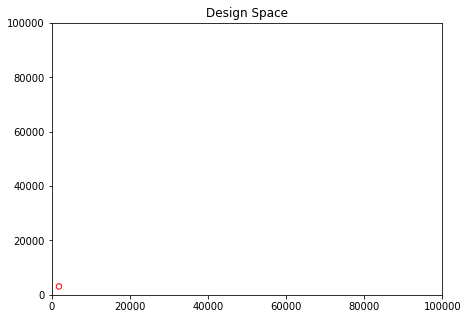

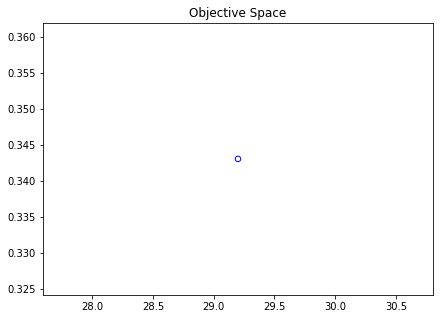

In [10]:
# visualization
%matplotlib inline
import matplotlib.pyplot as plt
xl, xu = MyProblem().bounds()
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()